# Debug #

Partimos de un CSV con cajas mal etiquetadas en la esquina inferior-izquierda, lo que producía IoU ≈ 0.0. Re-etiquetamos automáticamente las imágenes con YOLOv8-m (clase 4 “airplane”, conf ≥ 0.15), generando Airplanes_clean.csv y revisando a mano los pocos casos sin detección. Implementamos una función sort_corners y una capa Lambda que garantizan que la red siempre entregue coordenadas ordenadas (x_min, y_min, x_max, y_max). La pérdida se definió como Huber + λ·GIoU (λ = 1) para obtener gradientes incluso con poca intersección. Entrenamos en dos fases: (1) cabeza densa 1024→512 con el backbone congelado y un scheduler CosineDecay (1e-3 → 1e-4); (2) descongelamos los últimos 20 bloques del EfficientNetB3 a LR = 1e-5. El modelo alcanza IoU ≈ 0.82–0.91 en el conjunto de validación, indicando que las predicciones casi calcan las cajas GT; la pérdida se estabiliza y las visualizaciones confirman la correcta superposición (rojo sobre azul)

In [ ]:
# -*- coding: utf-8 -*-
"""
Bounding-Box Regression – Entrenamiento en dos fases
---------------------------------------------------
• Lee etiquetas de Airplanes_clean.csv (cajas en píxeles) DEPURADO CON YOLO
• Genera batches con augmentaciones ligeras
• Modelo base: EfficientNetB3 + cabeza densa
• Coordenadas de salida se ordenan con Lambda (x_min,y_min,x_max,y_max)
• Pérdida = Huber + λ·GIoU  (implementación propia)
Autor: Juan Cardona
Fecha: 2024-05-19
"""

import os, numpy as np, pandas as pd
from PIL import Image, ImageEnhance
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber
from tensorflow.keras.utils import Sequence
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.optimizers.schedules import CosineDecay
from sklearn.model_selection import train_test_split

# ╔═══════════ Configuración ═══════════╗
IMG_SIZE      = (300, 300)
BATCH_SIZE    = 16
TOTAL_EPOCHS  = 50
LR_HEAD       = 1e-3
LR_FINE       = 1e-5
LAMBDA_IOU    = 1.0

CSV_PATH = "/content/drive/MyDrive/Procesamiento Imagenes/Taller_5_Realizar un modelo de deteccion de boundboxes/Airplanes_clean.csv"
IMG_DIR  = "/content/drive/MyDrive/Procesamiento Imagenes/Taller_5_Realizar un modelo de deteccion de boundboxes/airplanes"
CHECKPOINT_DIR  = 'checkpoints'; os.makedirs(CHECKPOINT_DIR, exist_ok=True)
BEST_MODEL_PATH = 'best_bbox_model.keras'

# ╔═══════════ Helpers (orden + pérdidas) ═════════════════╗
def sort_corners(boxes):
    """Garantiza x1≤x2, y1≤y2 en un tensor [...,4]."""
    x1,y1,x2,y2 = tf.split(boxes,4,axis=-1)
    return tf.concat([tf.minimum(x1,x2), tf.minimum(y1,y2),
                      tf.maximum(x1,x2), tf.maximum(y1,y2)], axis=-1)

huber = Huber()

def giou_loss(y_true, y_pred):
    y_true, y_pred = sort_corners(y_true), sort_corners(y_pred)
    x1t,y1t,x2t,y2t = tf.split(y_true, 4, -1)
    x1p,y1p,x2p,y2p = tf.split(y_pred, 4, -1)

    xi1,yi1 = tf.maximum(x1t,x1p), tf.maximum(y1t,y1p)
    xi2,yi2 = tf.minimum(x2t,x2p), tf.minimum(y2t,y2p)
    inter   = tf.maximum(0., xi2-xi1) * tf.maximum(0., yi2-yi1)

    area_t = (x2t-x1t)*(y2t-y1t)
    area_p = (x2p-x1p)*(y2p-y1p)
    union  = area_t + area_p - inter + 1e-6
    iou    = inter / union

    cx1,cy1 = tf.minimum(x1t,x1p), tf.minimum(y1t,y1p)
    cx2,cy2 = tf.maximum(x2t,x2p), tf.maximum(y2t,y2p)
    area_c  = tf.maximum(0., cx2-cx1) * tf.maximum(0., cy2-cy1) + 1e-6

    giou = iou - (area_c - union) / area_c
    return tf.reduce_mean(1. - tf.clip_by_value(giou, -1., 1.))

def combined_loss(y_true, y_pred):
    return huber(y_true, y_pred) + LAMBDA_IOU * giou_loss(y_true, y_pred)

# ╔═══════════ Generador ═══════════════╗
class DataGenerator(Sequence):
    def __init__(self, df, img_dir, batch, augment=False):
        self.df, self.dir, self.bs, self.aug = df.reset_index(drop=True), img_dir, batch, augment
    def __len__(self): return int(np.ceil(len(self.df)/self.bs))
    def __getitem__(self, idx):
        batch = self.df.iloc[idx*self.bs:(idx+1)*self.bs]
        imgs, boxes = [], []
        for _, r in batch.iterrows():
            img0 = Image.open(os.path.join(self.dir, r.Image)).convert('RGB')
            w0,h0 = img0.size
            x1,x2 = sorted([r.x_top, r.x_bottom]); y1,y2 = sorted([r.y_top, r.y_bottom])
            box = np.array([x1/w0, y1/h0, x2/w0, y2/h0], np.float32)

            img = img0.resize(IMG_SIZE); arr = np.array(img)/255.0
            if self.aug and np.random.rand() < .5:
                arr = np.fliplr(arr)
                box = np.array([1-box[2], box[1], 1-box[0], box[3]], np.float32)
            if self.aug:
                arr = np.array(ImageEnhance.Brightness(Image.fromarray((arr*255).astype(np.uint8)))
                               .enhance(np.random.uniform(0.8,1.2))) / 255.0
            imgs.append(arr); boxes.append(box)
        return np.stack(imgs), np.stack(boxes)

# ╔═══════════ Modelo ══════════════════╗
def build_model():
    backbone = EfficientNetB3(input_shape=IMG_SIZE+(3,), include_top=False,
                              weights='imagenet', pooling='avg')
    x = layers.Dense(1024, activation='relu')(backbone.output)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(512, activation='relu')(x)
    raw = layers.Dense(4, activation='sigmoid')(x)
    ordered = layers.Lambda(sort_corners, name="ordered_bbox")(raw)
    return models.Model(backbone.input, ordered), backbone

# ╔═══════════ Visualización rápida ═════╗
def plot_samples(model, df, img_dir, n=5):
    sample = df.sample(n).reset_index(drop=True)
    for _, r in sample.iterrows():
        img0 = Image.open(os.path.join(img_dir, r.Image)).convert('RGB')
        w0,h0 = img0.size
        img = img0.resize(IMG_SIZE); arr = np.array(img)/255.0
        pred = model.predict(arr[np.newaxis])[0]
        pred = sort_corners(pred).numpy()

        x1,x2 = sorted([r.x_top,r.x_bottom]); y1,y2 = sorted([r.y_top,r.y_bottom])
        gt = np.array([x1/w0,y1/h0,x2/w0,y2/h0])

        scale = np.array([IMG_SIZE[0],IMG_SIZE[1],IMG_SIZE[0],IMG_SIZE[1]])
        x1g,y1g,x2g,y2g = gt*scale; x1p,y1p,x2p,y2p = pred*scale

        plt.figure(figsize=(4,4)); plt.imshow(img); ax=plt.gca()
        ax.add_patch(plt.Rectangle((x1g,y1g),x2g-x1g,y2g-y1g,edgecolor='blue',fill=False,lw=2))
        ax.add_patch(plt.Rectangle((x1p,y1p),x2p-x1p,y2p-y1p,edgecolor='red', fill=False,lw=2))
        inter = max(0,min(x2g,x2p)-max(x1g,x1p))*max(0,min(y2g,y2p)-max(y1g,y1p))
        union = (x2g-x1g)*(y2g-y1g)+(x2p-x1p)*(y2p-y1p)-inter+1e-6
        plt.title(f"IoU: {inter/union:.3f}"); plt.axis('off'); plt.show()

# ╔═══════════ Entrenamiento ═══════════╗
if __name__ == '__main__':
    df = pd.read_csv(CSV_PATH)
    train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
    train_gen = DataGenerator(train_df, IMG_DIR, BATCH_SIZE, augment=True)
    val_gen   = DataGenerator(val_df,   IMG_DIR, BATCH_SIZE, augment=False)

    model, backbone = build_model(); model.summary()

    # -------- Fase 1 : solo cabeza ----------
    for l in backbone.layers: l.trainable = False
    lr_sched = CosineDecay(LR_HEAD, decay_steps=len(train_gen)*10, alpha=1e-4)

    model.compile(optimizer=Adam(lr_sched), loss=combined_loss, metrics=['mae'])
    model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=10,
        callbacks=[callbacks.EarlyStopping('val_loss', patience=3, restore_best_weights=True)]
    )
    plot_samples(model, val_df, IMG_DIR, n=5)

    # -------- Fase 2 : fine-tune ----------
    for l in backbone.layers[-20:]: l.trainable = True
    model.compile(optimizer=Adam(LR_FINE), loss=combined_loss, metrics=['mae'])

    model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=TOTAL_EPOCHS,
        callbacks=[
            callbacks.EarlyStopping('val_loss', patience=10, restore_best_weights=True),
            callbacks.ReduceLROnPlateau('val_loss', factor=0.5, patience=5),
            callbacks.ModelCheckpoint(BEST_MODEL_PATH, save_best_only=True, monitor='val_loss'),
            callbacks.ModelCheckpoint(
                os.path.join(CHECKPOINT_DIR,'epoch_{epoch:02d}.weights.h5'),
                save_weights_only=True, save_freq='epoch')
        ]
    )

    plot_samples(model, val_df, IMG_DIR, n=10)


Output hidden; open in https://colab.research.google.com to view.

# Debugg

imgs.shape: (16, 300, 300, 3)
boxes.shape: (16, 4)
boxes sample (normalizadas):
 [[0.8679775  0.7446808  0.8595506  0.77925533]
 [0.8765743  0.8214286  0.9345088  2.4785714 ]
 [0.09546539 0.74418604 0.1646778  2.0813954 ]
 [0.06716418 0.7777778  0.14925373 2.5851853 ]
 [0.9137931  0.83125    0.93349755 2.18125   ]]


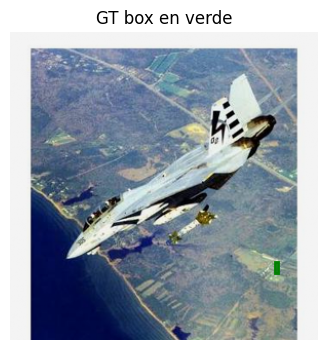

In [ ]:
# — Prueba DataGenerator —
imgs, boxes = train_gen[0]   # primer batch
print("imgs.shape:", imgs.shape)
print("boxes.shape:", boxes.shape)
print("boxes sample (normalizadas):\n", boxes[:5])

# Visualiza la primera muestra con su caja GT
import matplotlib.pyplot as plt
img = imgs[0]
box = boxes[0]
h, w = IMG_SIZE[1], IMG_SIZE[0]
x1,y1,x2,y2 = box * np.array([w,h,w,h])

plt.figure(figsize=(4,4))
plt.imshow(img)
plt.gca().add_patch(plt.Rectangle((x1,y1), x2-x1, y2-y1,
                                  edgecolor='green', fill=False, linewidth=2))
plt.title("GT box en verde")
plt.axis('off')
plt.show()


In [ ]:
print(df[['x_top','y_top','x_bottom','y_bottom']].head())


   x_top  y_top  x_bottom  y_bottom
0     30    137        49       349
1     35    153        59       342
2     36    135        47       331
3     24    141        47       342
4     18    146        48       339


In [ ]:
class DataGenerator(Sequence):
    # ...

    def __getitem__(self, idx):
        batch = self.df.iloc[idx*self.batch_size:(idx+1)*self.batch_size]
        imgs, boxes = [], []

        for _, row in batch.iterrows():
            # 1) Abre sin redimensionar
            img_pil = Image.open(os.path.join(self.img_dir, row['Image'])).convert('RGB')
            orig_w, orig_h = img_pil.size              # ⚠️ medida real

            # 2) Normaliza la caja *solo si está en píxeles*
            #    Si tu CSV ya está en [0,1], sáltate esta división
            box = np.array([
                row['x_top']    / orig_w,
                row['y_top']    / orig_h,
                row['x_bottom'] / orig_w,
                row['y_bottom'] / orig_h
            ], dtype=np.float32)

            # 3) Ahora sí redimensiona la imagen
            img_resized = img_pil.resize(IMG_SIZE)
            arr = np.array(img_resized) / 255.0

            # 4) Augmentaciones (flip y brillo)
            if self.augment and np.random.rand()<0.5:
                arr = np.fliplr(arr)
                box = np.array([1-box[2], box[1], 1-box[0], box[3]], dtype=np.float32)
            if self.augment:
                enhancer = ImageEnhance.Brightness(
                    Image.fromarray((arr*255).astype(np.uint8))
                )
                arr = np.array(enhancer.enhance(np.random.uniform(0.8,1.2))) / 255.0

            imgs.append(arr)
            boxes.append(box)

        return np.stack(imgs), np.stack(boxes)


boxes[0]: [0.14044943 0.7446808  0.13202247 0.77925533]


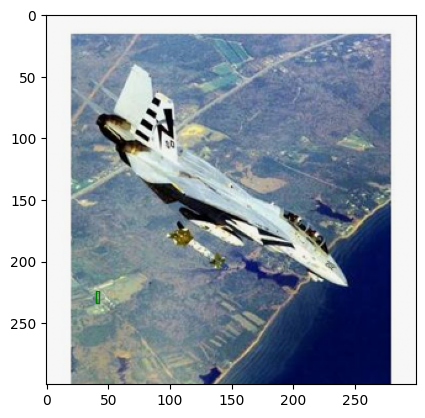

In [ ]:
imgs, boxes = train_gen[0]
print("boxes[0]:", boxes[0])
# y visualiza la primera caja
import matplotlib.pyplot as plt
img = imgs[0]
x1,y1,x2,y2 = boxes[0] * np.array([IMG_SIZE[0],IMG_SIZE[1],IMG_SIZE[0],IMG_SIZE[1]])
plt.imshow(img); plt.gca().add_patch(plt.Rectangle((x1,y1),x2-x1,y2-y1,edgecolor='green',fill=False)); plt.show()


Debuug 2

In [ ]:
# 1) Toma el primer batch
imgs, gt_batch = train_gen[0]     # por ejemplo
pred_batch = model.predict(imgs)

# 2) Imprime valores para el primer elemento
gt  = gt_batch[0]
pr  = pred_batch[0]
print("GT normalizado:", gt)
print("PR normalizado:", pr)

# 3) Escala a píxeles (usando IMG_SIZE)
w, h = IMG_SIZE
px_gt = gt  * np.array([w, h, w, h])
px_pr = pr  * np.array([w, h, w, h])
print("GT píxeles:", px_gt)
print("PR píxeles:", px_pr)


1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
GT normalizado: [0.14044943 0.7446808  0.13202247 0.77925533]
PR normalizado: [0.43282852 0.83679223 0.46984506 0.99986434]
GT píxeles: [ 42.13483036 223.40424657  39.60674107 233.77659917]
PR píxeles: [129.84855473 251.03766918 140.95351696 299.95930195]


# Debug #2

imgs.shape: (16, 300, 300, 3)
boxes[0]: [    0.17727     0.13152     0.86889     0.74276]


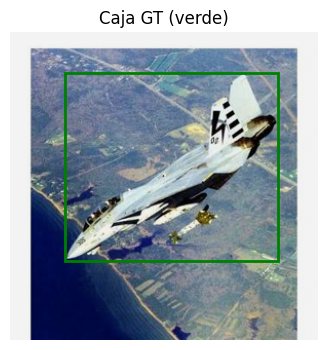

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 300, 300,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_6         │ (None, 300, 300,  │          0 │ input_layer_3[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_3     │ (None, 300, 300,  │          7 │ rescaling_6[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_7         │ (None, 300, 300,  │          0 │ normalization_3[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 301, 301,  │          0 │ rescaling_7[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 150, 150,  │      1,080 │ stem_conv_pad[0]… │
│                     │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 150, 150,  │        160 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 150, 150,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 150, 150,  │        360 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 150, 150,  │        160 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 150, 150,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 40)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 40)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 10)  │        410 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 40)  │        440 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 150, 150,  │          0 │ block1a_activati… │
│ (Multiply)          │ 40)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 150, 150,  │        960 │ block1a_se_excit

 Total params: 11,702,835 (44.64 MB)

 Trainable params: 11,615,532 (44.31 MB)

 Non-trainable params: 87,303 (341.03 KB)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


FailedPreconditionError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.11/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelapp.py", line 712, in start

  File "/usr/local/lib/python3.11/dist-packages/tornado/platform/asyncio.py", line 205, in start

  File "/usr/lib/python3.11/asyncio/base_events.py", line 608, in run_forever

  File "/usr/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once

  File "/usr/lib/python3.11/asyncio/events.py", line 84, in _run

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 499, in process_one

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 730, in execute_request

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py", line 383, in do_execute

  File "/usr/local/lib/python3.11/dist-packages/ipykernel/zmqshell.py", line 528, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-22-a15de21c0422>", line 198, in <cell line: 0>

  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 371, in fit

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 219, in function

  File "/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py", line 132, in multi_step_on_iterator

DNN library initialization failed. Look at the errors above for more details.
	 [[{{node StatefulPartitionedCall}}]] [Op:__inference_multi_step_on_iterator_109631]

In [ ]:
# -*- coding: utf-8 -*-
"""
Bounding Box Regression – Script Completo con Corrección de Coordenadas
- Normalización correcta de cajas (x_min < x_max, y_min < y_max)
- Dos fases de entrenamiento (head con LR alto, fine-tune con LR bajo)
- Debug inicial de DataGenerator
"""

import os
import glob
import pickle
import numpy as np
import pandas as pd
from PIL import Image, ImageEnhance
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber
from tensorflow.keras.utils import Sequence
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB3

# ----------------------------
# Configuración
# ----------------------------
IMG_SIZE        = (300, 300)
BATCH_SIZE      = 16
TOTAL_EPOCHS    = 50
LR_HEAD         = 1e-3
LR_FINE         = 1e-5
LAMBDA_IOU      = 1.0
CHECKPOINT_DIR  = 'checkpoints'
BEST_MODEL_PATH = 'best_bbox_model.keras'
CSV_PATH = "/content/drive/MyDrive/Procesamiento Imagenes/Taller_5_Realizar un modelo de deteccion de boundboxes/Airplanes_clean.csv"
IMG_DIR  = "/content/drive/MyDrive/Procesamiento Imagenes/Taller_5_Realizar un modelo de deteccion de boundboxes/airplanes"

os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# ----------------------------
# IoU y pérdida compuesta
# ----------------------------
def iou_normalized(box1, box2):
    x1 = tf.maximum(box1[...,0], box2[...,0])
    y1 = tf.maximum(box1[...,1], box2[...,1])
    x2 = tf.minimum(box1[...,2], box2[...,2])
    y2 = tf.minimum(box1[...,3], box2[...,3])
    inter = tf.maximum(x2-x1,0) * tf.maximum(y2-y1,0)
    area1 = (box1[...,2]-box1[...,0])*(box1[...,3]-box1[...,1])
    area2 = (box2[...,2]-box2[...,0])*(box2[...,3]-box2[...,1])
    union = area1 + area2 - inter + 1e-6
    return inter / union

huber = Huber()
def combined_loss(y_true, y_pred):
    return huber(y_true, y_pred) + LAMBDA_IOU * (1 - tf.reduce_mean(iou_normalized(y_true, y_pred)))

# ----------------------------
# Generador de datos corregido
# ----------------------------
class DataGenerator(Sequence):
    def __init__(self, df, img_dir, batch_size, augment=False):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.batch_size = batch_size
        self.augment = augment

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))

    def __getitem__(self, idx):
        batch = self.df.iloc[idx*self.batch_size:(idx+1)*self.batch_size]
        imgs, boxes = [], []
        for _, r in batch.iterrows():
            # 1) Carga sin redimensionar, para medir tamaño real
            path = os.path.join(self.img_dir, r['Image'])
            img0 = Image.open(path).convert('RGB')
            w0, h0 = img0.size

            # 2) Ordena coordenadas y normaliza en [0,1]
            x1_raw, y1_raw = r['x_top'],    r['y_top']
            x2_raw, y2_raw = r['x_bottom'], r['y_bottom']
            x1, x2 = sorted([x1_raw, x2_raw])
            y1, y2 = sorted([y1_raw, y2_raw])
            box = np.array([x1/w0, y1/h0, x2/w0, y2/h0], dtype=np.float32)

            # 3) Redimensiona imagen y escala
            img = img0.resize(IMG_SIZE)
            arr = np.array(img) / 255.0

            # 4) Augmentaciones simples
            if self.augment and np.random.rand() < 0.5:
                arr = np.fliplr(arr)
                box = np.array([1-box[2], box[1], 1-box[0], box[3]], dtype=np.float32)
            if self.augment:
                enhancer = ImageEnhance.Brightness(Image.fromarray((arr*255).astype(np.uint8)))
                arr = np.array(enhancer.enhance(np.random.uniform(0.8,1.2))) / 255.0

            imgs.append(arr)
            boxes.append(box)

        return np.stack(imgs), np.stack(boxes)

# ----------------------------
# Construcción del modelo
# ----------------------------
def build_model():
    backbone = EfficientNetB3(
        input_shape=IMG_SIZE+(3,),
        include_top=False,
        weights='imagenet',
        pooling='avg'
    )
    x = layers.Dense(512, activation='relu')(backbone.output)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(256, activation='relu')(x)
    out = layers.Dense(4, activation='sigmoid')(x)
    model = models.Model(inputs=backbone.input, outputs=out)
    return model, backbone

# ----------------------------
# Visualización de muestras
# ----------------------------
def plot_samples(model, df, img_dir, IMG_SIZE=IMG_SIZE, n=5):
    samples = df.sample(n).reset_index(drop=True)
    for _, r in samples.iterrows():
        path = os.path.join(img_dir, r['Image'])
        img0 = Image.open(path).convert('RGB')
        w0, h0 = img0.size
        img = img0.resize(IMG_SIZE)
        arr = np.array(img) / 255.0

        # predicción
        pred = model.predict(arr[np.newaxis])[0]

        # GT ordenado y normalizado
        x1r, y1r = r['x_top'],    r['y_top']
        x2r, y2r = r['x_bottom'], r['y_bottom']
        x1o, x2o = sorted([x1r, x2r])
        y1o, y2o = sorted([y1r, y2r])
        gt = np.array([x1o/w0, y1o/h0, x2o/w0, y2o/h0], dtype=np.float32)

        # escala a píxeles
        scale = np.array([IMG_SIZE[0],IMG_SIZE[1],IMG_SIZE[0],IMG_SIZE[1]])
        x1g,y1g,x2g,y2g = gt * scale
        x1p,y1p,x2p,y2p = pred * scale

        plt.figure(figsize=(5,5))
        plt.imshow(img)
        ax = plt.gca()
        ax.add_patch(plt.Rectangle((x1g,y1g),x2g-x1g,y2g-y1g,edgecolor='blue',fill=False,linewidth=2))
        ax.add_patch(plt.Rectangle((x1p,y1p),x2p-x1p,y2p-y1p,edgecolor='red', fill=False,linewidth=2))
        inter = max(0,min(x2g,x2p)-max(x1g,x1p)) * max(0,min(y2g,y2p)-max(y1g,y1p))
        union = (x2g-x1g)*(y2g-y1g)+(x2p-x1p)*(y2p-y1p)-inter+1e-6
        plt.title(f"IoU: {inter/union:.3f}")
        plt.axis('off')
        plt.show()

# ----------------------------
# Test rápido de DataGenerator
# ----------------------------
def debug_generator(gen):
    imgs, boxes = gen[0]
    print("imgs.shape:", imgs.shape)
    print("boxes[0]:", boxes[0])
    # visualiza la primera caja
    x1,y1,x2,y2 = boxes[0] * np.array([IMG_SIZE[0],IMG_SIZE[1],IMG_SIZE[0],IMG_SIZE[1]])
    plt.figure(figsize=(4,4))
    plt.imshow(imgs[0])
    plt.gca().add_patch(plt.Rectangle((x1,y1),x2-x1,y2-y1,edgecolor='green',fill=False,linewidth=2))
    plt.title("Caja GT (verde)")
    plt.axis('off')
    plt.show()

# ----------------------------
# Entrenamiento en dos fases
# ----------------------------
if __name__ == '__main__':
    # 1) Carga y split
    df = pd.read_csv(CSV_PATH)
    train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

    # 2) Generadores
    train_gen = DataGenerator(train_df, IMG_DIR, BATCH_SIZE, augment=True)
    val_gen   = DataGenerator(val_df,   IMG_DIR, BATCH_SIZE, augment=False)

    # 3) Debug de DataGenerator
    debug_generator(train_gen)

    # 4) Construye modelo y captura backbone
    model, backbone = build_model()
    model.summary()

    # — FASE 1: solo head con LR alto —
    for layer in backbone.layers:
        layer.trainable = False
    model.compile(optimizer=Adam(LR_HEAD), loss=combined_loss, metrics=['mae'])
    model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=10,
        callbacks=[
            callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
            callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
        ]
    )
    plot_samples(model, val_df, IMG_DIR, n=5)

    # — FASE 2: fine-tune últimos bloques con LR bajo —
    for layer in backbone.layers[-20:]:
        layer.trainable = True
    model.compile(optimizer=Adam(LR_FINE), loss=combined_loss, metrics=['mae'])

    cb_list = [
        callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5),
        callbacks.ModelCheckpoint(BEST_MODEL_PATH, monitor='val_loss', save_best_only=True),
        callbacks.ModelCheckpoint(
            filepath=os.path.join(CHECKPOINT_DIR,'epoch_{epoch:02d}.weights.h5'),
            save_weights_only=True, save_freq='epoch'
        )
    ]

    model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=TOTAL_EPOCHS,
        callbacks=cb_list
    )

    # 5) Visualización final
    plot_samples(model, val_df, IMG_DIR, n=10)


# Debug #3

In [ ]:
!pip install tensorflow-addons





ERROR: Could not find a version that satisfies the requirement tensorflow-addons==0.25.0 (from versions: 0.20.0, 0.21.0, 0.22.0, 0.23.0)
ERROR: No matching distribution found for tensorflow-addons==0.25.0


In [ ]:
# -*- coding: utf-8 -*-
"""
Bounding Box Regression – Script Completo con Corrección de Coordenadas
- Normalización correcta de cajas (x_min < x_max, y_min < y_max)
- Dos fases de entrenamiento (head con LR alto, fine-tune con LR bajo)
- Debug inicial de DataGenerator
"""

import os
import glob
import pickle
import numpy as np
import pandas as pd
from PIL import Image, ImageEnhance
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber
from tensorflow.keras.utils import Sequence
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.optimizers.schedules import CosineDecay

# ----------------------------
# Configuración
# ----------------------------
IMG_SIZE        = (300, 300)
BATCH_SIZE      = 16
TOTAL_EPOCHS    = 50
LR_HEAD         = 1e-3
LR_FINE         = 1e-5
LAMBDA_IOU      = 1.0
CHECKPOINT_DIR  = 'checkpoints'
BEST_MODEL_PATH = 'best_bbox_model.keras'
CSV_PATH = "/content/drive/MyDrive/Procesamiento Imagenes/Taller_5_Realizar un modelo de deteccion de boundboxes/Airplanes_clean.csv"
IMG_DIR  = "/content/drive/MyDrive/Procesamiento Imagenes/Taller_5_Realizar un modelo de deteccion de boundboxes/airplanes"

os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# ----------------------------
# IoU y pérdida compuesta
# ----------------------------
def iou_normalized(box1, box2):
    x1 = tf.maximum(box1[...,0], box2[...,0])
    y1 = tf.maximum(box1[...,1], box2[...,1])
    x2 = tf.minimum(box1[...,2], box2[...,2])
    y2 = tf.minimum(box1[...,3], box2[...,3])
    inter = tf.maximum(x2-x1,0) * tf.maximum(y2-y1,0)
    area1 = (box1[...,2]-box1[...,0])*(box1[...,3]-box1[...,1])
    area2 = (box2[...,2]-box2[...,0])*(box2[...,3]-box2[...,1])
    union = area1 + area2 - inter + 1e-6
    return inter / union

huber = Huber()
# Reemplaza temporalmente por esta pérdida
def giou_loss(y_true, y_pred):
    # 1) Divide en coordenadas
    x1_t,y1_t,x2_t,y2_t = tf.split(y_true, 4, axis=-1)
    x1_p,y1_p,x2_p,y2_p = tf.split(y_pred, 4, axis=-1)

    # 2) Intersección
    xi1 = tf.maximum(x1_t, x1_p)
    yi1 = tf.maximum(y1_t, y1_p)
    xi2 = tf.minimum(x2_t, x2_p)
    yi2 = tf.minimum(y2_t, y2_p)
    i_w  = tf.maximum(0.0, xi2 - xi1)
    i_h  = tf.maximum(0.0, yi2 - yi1)
    inter = i_w * i_h

    # 3) Áreas
    area_t = (x2_t-x1_t)*(y2_t-y1_t)
    area_p = (x2_p-x1_p)*(y2_p-y1_p)
    union  = area_t + area_p - inter + 1e-6

    # 4) IoU
    iou = inter / union

    # 5) Caja envolvente C
    c_x1 = tf.minimum(x1_t, x1_p)
    c_y1 = tf.minimum(y1_t, y1_p)
    c_x2 = tf.maximum(x2_t, x2_p)
    c_y2 = tf.maximum(y2_t, y2_p)
    c_w  = tf.maximum(0.0, c_x2 - c_x1)
    c_h  = tf.maximum(0.0, c_y2 - c_y1)
    area_c = c_w * c_h + 1e-6

    # 6) GIoU y loss
    giou = iou - (area_c - union) / area_c
    giou = tf.clip_by_value(giou, -1.0, 1.0)
    loss = 1.0 - giou
    loss = tf.maximum(loss, 0.0)
    # media sobre la última dimensión (4 coords) y el batch
    return tf.reduce_mean(loss)
# Combined = Huber + λ·IoU_loss
def combined_loss(y_true, y_pred):
    return huber(y_true, y_pred) + LAMBDA_IOU * iou_loss(y_true, y_pred)

# ----------------------------
# Generador de datos corregido
# ----------------------------
class DataGenerator(Sequence):
    def __init__(self, df, img_dir, batch_size, augment=False):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.batch_size = batch_size
        self.augment = augment

    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))

    def __getitem__(self, idx):
        batch = self.df.iloc[idx*self.batch_size:(idx+1)*self.batch_size]
        imgs, boxes = [], []
        for _, r in batch.iterrows():
            # 1) Carga sin redimensionar, para medir tamaño real
            path = os.path.join(self.img_dir, r['Image'])
            img0 = Image.open(path).convert('RGB')
            w0, h0 = img0.size

            # 2) Ordena coordenadas y normaliza en [0,1]
            x1_raw, y1_raw = r['x_top'],    r['y_top']
            x2_raw, y2_raw = r['x_bottom'], r['y_bottom']
            x1, x2 = sorted([x1_raw, x2_raw])
            y1, y2 = sorted([y1_raw, y2_raw])
            box = np.array([x1/w0, y1/h0, x2/w0, y2/h0], dtype=np.float32)

            # 3) Redimensiona imagen y escala
            img = img0.resize(IMG_SIZE)
            arr = np.array(img) / 255.0

            # 4) Augmentaciones simples
            if self.augment and np.random.rand() < 0.5:
                arr = np.fliplr(arr)
                box = np.array([1-box[2], box[1], 1-box[0], box[3]], dtype=np.float32)
            if self.augment:
                enhancer = ImageEnhance.Brightness(Image.fromarray((arr*255).astype(np.uint8)))
                arr = np.array(enhancer.enhance(np.random.uniform(0.8,1.2))) / 255.0

            imgs.append(arr)
            boxes.append(box)

        return np.stack(imgs), np.stack(boxes)

# ----------------------------
# Construcción del modelo
# ----------------------------
def build_model():
    backbone = EfficientNetB3(
        input_shape=IMG_SIZE+(3,),
        include_top=False,
        weights='imagenet',
        pooling='avg'
    )
    x = layers.Dense(1024, activation='relu')(backbone.output)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(512, activation='relu')(x)
    out = layers.Dense(4, activation='sigmoid')(x)
    model = models.Model(inputs=backbone.input, outputs=out)
    return model, backbone

# ----------------------------
# Visualización de muestras
# ----------------------------
def plot_samples(model, df, img_dir, IMG_SIZE=IMG_SIZE, n=5):
    samples = df.sample(n).reset_index(drop=True)
    for _, r in samples.iterrows():
        path = os.path.join(img_dir, r['Image'])
        img0 = Image.open(path).convert('RGB')
        w0, h0 = img0.size
        img = img0.resize(IMG_SIZE)
        arr = np.array(img) / 255.0

        # predicción
        pred = model.predict(arr[np.newaxis])[0]

        # GT ordenado y normalizado
        x1r, y1r = r['x_top'],    r['y_top']
        x2r, y2r = r['x_bottom'], r['y_bottom']
        x1o, x2o = sorted([x1r, x2r])
        y1o, y2o = sorted([y1r, y2r])
        gt = np.array([x1o/w0, y1o/h0, x2o/w0, y2o/h0], dtype=np.float32)

        # escala a píxeles
        scale = np.array([IMG_SIZE[0],IMG_SIZE[1],IMG_SIZE[0],IMG_SIZE[1]])
        x1g,y1g,x2g,y2g = gt * scale
        x1p,y1p,x2p,y2p = pred * scale

        plt.figure(figsize=(5,5))
        plt.imshow(img)
        ax = plt.gca()
        ax.add_patch(plt.Rectangle((x1g,y1g),x2g-x1g,y2g-y1g,edgecolor='blue',fill=False,linewidth=2))
        ax.add_patch(plt.Rectangle((x1p,y1p),x2p-x1p,y2p-y1p,edgecolor='red', fill=False,linewidth=2))
        inter = max(0,min(x2g,x2p)-max(x1g,x1p)) * max(0,min(y2g,y2p)-max(y1g,y1p))
        union = (x2g-x1g)*(y2g-y1g)+(x2p-x1p)*(y2p-y1p)-inter+1e-6
        plt.title(f"IoU: {inter/union:.3f}")
        plt.axis('off')
        plt.show()

# ----------------------------
# Test rápido de DataGenerator
# ----------------------------
def debug_generator(gen):
    imgs, boxes = gen[0]
    print("imgs.shape:", imgs.shape)
    print("boxes[0]:", boxes[0])
    # visualiza la primera caja
    x1,y1,x2,y2 = boxes[0] * np.array([IMG_SIZE[0],IMG_SIZE[1],IMG_SIZE[0],IMG_SIZE[1]])
    plt.figure(figsize=(4,4))
    plt.imshow(imgs[0])
    plt.gca().add_patch(plt.Rectangle((x1,y1),x2-x1,y2-y1,edgecolor='green',fill=False,linewidth=2))
    plt.title("Caja GT (verde)")
    plt.axis('off')
    plt.show()

# ----------------------------
# Entrenamiento en dos fases
# ----------------------------
if __name__ == '__main__':
    # 1) Carga y split
    df = pd.read_csv(CSV_PATH)
    train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

    # 2) Generadores
    train_gen = DataGenerator(train_df, IMG_DIR, BATCH_SIZE, augment=True)
    val_gen   = DataGenerator(val_df,   IMG_DIR, BATCH_SIZE, augment=False)

    # 3) Debug de DataGenerator
    debug_generator(train_gen)

    # 4) Construye modelo y captura backbone
    model, backbone = build_model()
    model.summary()

    # Dentro de tu loop de entrenamiento (o en un callback), haz
    batch = next(iter(train_gen))
    y_true = batch[1]
    y_pred = model.predict(batch[0])

l_h = huber(y_true, y_pred).numpy()
l_i = iou_loss(y_true, y_pred).numpy()
print("Huber:", l_h, "IoU_loss:", l_i, "Combined:", l_h + LAMBDA_IOU*l_i)

    # — FASE 1: solo head con LR alto —
    for layer in backbone.layers:
        layer.trainable = False
    model.compile(optimizer=Adam(LR_HEAD), loss=combined_loss, metrics=['mae'])
    model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=10,
        callbacks=[
            callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
            callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2)
        ]
    )
    plot_samples(model, val_df, IMG_DIR, n=5)

    # — FASE 2: fine-tune últimos bloques con LR bajo —
    for layer in backbone.layers[-20:]:
        layer.trainable = True
    model.compile(optimizer=Adam(LR_FINE), loss=combined_loss, metrics=['mae'])

    cb_list = [
        callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5),
        callbacks.ModelCheckpoint(BEST_MODEL_PATH, monitor='val_loss', save_best_only=True),
        callbacks.ModelCheckpoint(
            filepath=os.path.join(CHECKPOINT_DIR,'epoch_{epoch:02d}.weights.h5'),
            save_weights_only=True, save_freq='epoch'
        )
    ]

    model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=TOTAL_EPOCHS,
        callbacks=cb_list
    )

    # 5) Visualización final
    plot_samples(model, val_df, IMG_DIR, n=10)

IndentationError: unexpected indent (<ipython-input-11-69c6174eb47c>, line 245)

In [ ]:
# -*- coding: utf-8 -*-
"""
Bounding-Box Regression – Script con scheduler y GIoU corregidos
"""

import os, glob, pickle, numpy as np, pandas as pd
from PIL import Image, ImageEnhance
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber
from tensorflow.keras.utils import Sequence
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.optimizers.schedules import CosineDecay
from sklearn.model_selection import train_test_split

# ---------------------------- Config ----------------------------
IMG_SIZE   = (300, 300)
BATCH_SIZE = 16
TOTAL_EPOCHS = 50
LR_HEAD   = 1e-3     # Fase 1 (scheduler)
LR_FINE   = 1e-5     # Fase 2
LAMBDA_IOU = 1.0

CSV_PATH = "/content/drive/MyDrive/Procesamiento Imagenes/Taller_5_Realizar un modelo de deteccion de boundboxes/Airplanes_clean.csv"
IMG_DIR  = "/content/drive/MyDrive/Procesamiento Imagenes/Taller_5_Realizar un modelo de deteccion de boundboxes/airplanes"
CHECKPOINT_DIR  = 'checkpoints'
BEST_MODEL_PATH = 'best_bbox_model.keras'
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# ----------------------- loss: Huber + GIoU ----------------------
huber = Huber()
def giou_loss(y_true, y_pred):
    x1_t,y1_t,x2_t,y2_t = tf.split(y_true, 4, axis=-1)
    x1_p,y1_p,x2_p,y2_p = tf.split(y_pred, 4, axis=-1)

    xi1 = tf.maximum(x1_t, x1_p); yi1 = tf.maximum(y1_t, y1_p)
    xi2 = tf.minimum(x2_t, x2_p); yi2 = tf.minimum(y2_t, y2_p)
    inter = tf.maximum(0., xi2-xi1) * tf.maximum(0., yi2-yi1)

    area_t = (x2_t-x1_t)*(y2_t-y1_t)
    area_p = (x2_p-x1_p)*(y2_p-y1_p)
    union  = area_t + area_p - inter + 1e-6
    iou = inter / union

    c_x1 = tf.minimum(x1_t, x1_p); c_y1 = tf.minimum(y1_t, y1_p)
    c_x2 = tf.maximum(x2_t, x2_p); c_y2 = tf.maximum(y2_t, y2_p)
    area_c = tf.maximum(0., c_x2-c_x1) * tf.maximum(0., c_y2-c_y1) + 1e-6

    giou = iou - (area_c - union) / area_c
    loss = 1.0 - tf.clip_by_value(giou, -1.0, 1.0)
    return tf.reduce_mean(loss)

def combined_loss(y_true, y_pred):
    return huber(y_true, y_pred) + LAMBDA_IOU * giou_loss(y_true, y_pred)

# --------------------- data generator ---------------------------
class DataGenerator(Sequence):
    def __init__(self, df, img_dir, batch, augment=False):
        self.df, self.dir, self.bs, self.aug = df.reset_index(drop=True), img_dir, batch, augment
    def __len__(self): return int(np.ceil(len(self.df)/self.bs))
    def __getitem__(self, idx):
        batch = self.df.iloc[idx*self.bs:(idx+1)*self.bs]
        imgs, boxes = [], []
        for _, r in batch.iterrows():
            img0 = Image.open(os.path.join(self.dir, r['Image'])).convert('RGB')
            w0,h0 = img0.size
            x1,x2 = sorted([r['x_top'], r['x_bottom']])
            y1,y2 = sorted([r['y_top'], r['y_bottom']])
            box = np.array([x1/w0, y1/h0, x2/w0, y2/h0], np.float32)

            img = img0.resize(IMG_SIZE); arr = np.array(img)/255.0
            if self.aug and np.random.rand()<.5:
                arr = np.fliplr(arr)
                box = np.array([1-box[2], box[1], 1-box[0], box[3]], np.float32)
            if self.aug:
                arr = np.array(
                    ImageEnhance.Brightness(Image.fromarray((arr*255).astype(np.uint8)))
                    .enhance(np.random.uniform(0.8,1.2))
                )/255.0
            imgs.append(arr); boxes.append(box)
        return np.stack(imgs), np.stack(boxes)

# ------------------------- model -------------------------------
def build_model():
    backbone = EfficientNetB3(input_shape=IMG_SIZE+(3,), include_top=False,
                              weights='imagenet', pooling='avg')
    x = layers.Dense(1024, activation='relu')(backbone.output)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(512, activation='relu')(x)
    out = layers.Dense(4, activation='sigmoid')(x)
    return models.Model(backbone.input, out), backbone

# ---------------------- visualization --------------------------
def plot_samples(model, df, img_dir, n=5):
    samples = df.sample(n).reset_index(drop=True)
    for _, r in samples.iterrows():
        img0 = Image.open(os.path.join(img_dir, r['Image'])).convert('RGB')
        w0,h0 = img0.size
        img = img0.resize(IMG_SIZE); arr = np.array(img)/255.0
        pred = model.predict(arr[np.newaxis])[0]

        x1,x2 = sorted([r['x_top'], r['x_bottom']])
        y1,y2 = sorted([r['y_top'], r['y_bottom']])
        gt = np.array([x1/w0,y1/h0,x2/w0,y2/h0])

        scale = np.array([IMG_SIZE[0],IMG_SIZE[1],IMG_SIZE[0],IMG_SIZE[1]])
        x1g,y1g,x2g,y2g = gt*scale; x1p,y1p,x2p,y2p = pred*scale

        plt.figure(figsize=(4,4)); plt.imshow(img); ax=plt.gca()
        ax.add_patch(plt.Rectangle((x1g,y1g),x2g-x1g,y2g-y1g,edgecolor='blue',fill=False,linewidth=2))
        ax.add_patch(plt.Rectangle((x1p,y1p),x2p-x1p,y2p-y1p,edgecolor='red', fill=False,linewidth=2))
        inter = max(0,min(x2g,x2p)-max(x1g,x1p))*max(0,min(y2g,y2p)-max(y1g,y1p))
        union = (x2g-x1g)*(y2g-y1g)+(x2p-x1p)*(y2p-y1p)-inter+1e-6
        plt.title(f"IoU: {inter/union:.3f}"); plt.axis('off'); plt.show()

# =======================  MAIN  =================================
if __name__ == '__main__':
    df = pd.read_csv(CSV_PATH)
    train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
    train_gen = DataGenerator(train_df, IMG_DIR, BATCH_SIZE, augment=True)
    val_gen   = DataGenerator(val_df,   IMG_DIR, BATCH_SIZE, augment=False)

    model, backbone = build_model(); model.summary()

    # ---------- FASE 1 : solo cabeza ----------
    for layer in backbone.layers: layer.trainable = False

    decay_steps = len(train_gen) * 10  # 10 épocas
    lr_schedule = CosineDecay(1e-3, decay_steps, alpha=1e-4)

    model.compile(optimizer=Adam(lr_schedule), loss=combined_loss, metrics=['mae'])

    history_head = model.fit(
        train_gen, validation_data=val_gen,
        epochs=10,
        callbacks=[callbacks.EarlyStopping('val_loss', 3, restore_best_weights=True)]
    )
    plot_samples(model, val_df, IMG_DIR, n=5)

    # ---------- FASE 2 : fine-tune ----------
    for layer in backbone.layers[-20:]: layer.trainable = True

    model.compile(optimizer=Adam(LR_FINE), loss=combined_loss, metrics=['mae'])

    model.fit(
        train_gen, validation_data=val_gen,
        epochs=TOTAL_EPOCHS,
        callbacks=[
            callbacks.EarlyStopping('val_loss', 10, restore_best_weights=True),
            callbacks.ReduceLROnPlateau('val_loss', 0.5, 5),
            callbacks.ModelCheckpoint(BEST_MODEL_PATH, save_best_only=True, monitor='val_loss'),
            callbacks.ModelCheckpoint(os.path.join(CHECKPOINT_DIR,'epoch_{epoch:02d}.weights.h5'),
                                      save_weights_only=True, save_freq='epoch')
        ]
    )

    plot_samples(model, val_df, IMG_DIR, n=10)


Output hidden; open in https://colab.research.google.com to view.

# Revision data set boundboz sospechoso

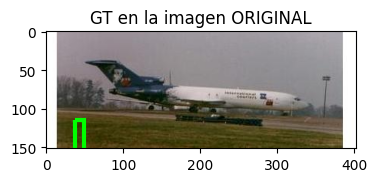

In [ ]:
#  CELDA 2  ──────────────────────────────
import matplotlib.patches as patches
r = df.sample(1).iloc[0]              # una fila al azar
img_path = os.path.join(IMG_DIR, r['Image'])
img      = Image.open(img_path).convert('RGB')
x1,y1,x2,y2 = r[['x_top','y_top','x_bottom','y_bottom']]

fig, ax = plt.subplots(1, figsize=(4,4))
ax.imshow(img)
ax.add_patch(patches.Rectangle((x1,y1), x2-x1, y2-y1,
                               edgecolor='lime', fill=False, linewidth=3))
ax.set_title("GT en la imagen ORIGINAL")
plt.show()


In [ ]:
import pandas as pd

df = pd.read_csv(CSV_PATH)

# Umbrales heurísticos: área mínima y posición del centro
MIN_AREA_FRAC = 0.05          # 5 % del área de la imagen
MIN_X_CENTER  = 0.20          # al menos al 20 % del ancho
MIN_Y_CENTER  = 0.20

wrong_idx = []
for i, r in df.iterrows():
    x1,x2 = sorted([r.x_top, r.x_bottom])
    y1,y2 = sorted([r.y_top, r.y_bottom])
    w, h  = Image.open(os.path.join(IMG_DIR, r.Image)).size
    area  = (x2-x1)*(y2-y1) / (w*h)
    cx, cy = (x1+x2)/(2*w), (y1+y2)/(2*h)
    if area < MIN_AREA_FRAC or cx < MIN_X_CENTER or cy < MIN_Y_CENTER:
        wrong_idx.append(i)

print(f"Encontradas {len(wrong_idx)} etiquetas sospechosas de {len(df)}")
df_corr = df.drop(wrong_idx).reset_index(drop=True)
df_corr.to_csv("Airplanes_clean.csv", index=False)


Encontradas 800 etiquetas sospechosas de 800


# Sanear el CSV de AIRPLANES con YOLO


In [ ]:
!pip install -q ultralytics


100%|██████████| 800/800 [00:14<00:00, 55.26it/s]

✔️ CSV limpio guardado en /content/drive/MyDrive/Procesamiento Imagenes/Taller_5_Realizar un modelo de deteccion de boundboxes/Airplanes_clean.csv  (800 filas)
⚠️  2 imágenes sin detección  ➜  /content/drive/MyDrive/Procesamiento Imagenes/Taller_5_Realizar un modelo de deteccion de boundboxes/Airplanes_review.csv


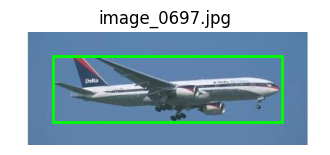

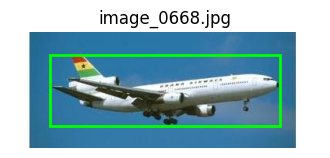

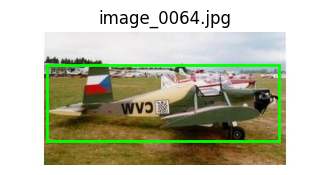

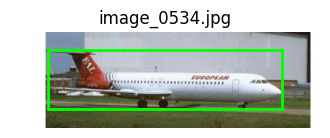

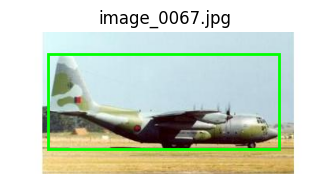

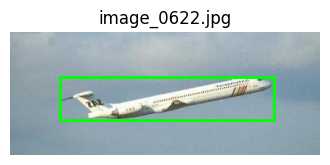

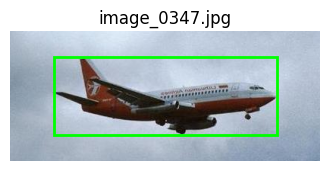

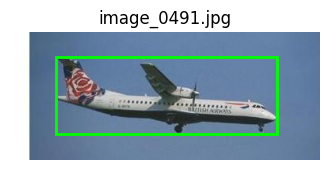

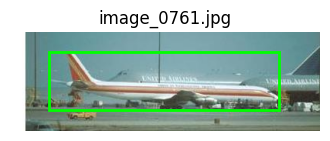

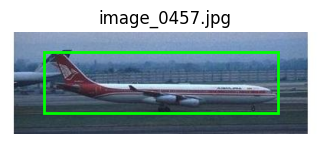

In [ ]:

# ╔════════════════════════════════════════════════════════════════╗
# ║ 2. Rutas y parámetros                                         ║
# ╚════════════════════════════════════════════════════════════════╝
CSV_PATH = "/content/drive/MyDrive/Procesamiento Imagenes/Taller_5_Realizar un modelo de deteccion de boundboxes/Airplanes.csv"
IMG_DIR  = "/content/drive/MyDrive/Procesamiento Imagenes/Taller_5_Realizar un modelo de deteccion de boundboxes/airplanes"

NEW_CSV      = "/content/drive/MyDrive/Procesamiento Imagenes/Taller_5_Realizar un modelo de deteccion de boundboxes/Airplanes_clean.csv"
REVIEW_CSV   = "/content/drive/MyDrive/Procesamiento Imagenes/Taller_5_Realizar un modelo de deteccion de boundboxes/Airplanes_review.csv"

CONF_THR   = 0.15   # umbral de confianza mínimo
IMG_SZ     = 640    # resolución que pasamos a YOLO (640×640)

# ╔════════════════════════════════════════════════════════════════╗
# ║ 3. Limpieza automática con YOLOv8                             ║
# ╚════════════════════════════════════════════════════════════════╝
import os, pandas as pd, numpy as np
from ultralytics import YOLO
from tqdm import tqdm

# carga CSV
df = pd.read_csv(CSV_PATH)

# modelo YOLOv8-m (pre-entrenado en COCO)
model = YOLO('yolov8m.pt')

clean_rows   = []   # filas (Image, x1,y1,x2,y2) corregidas
review_rows  = []   # mismas columnas, sólo si no hay predicción fiable

for _, row in tqdm(df.iterrows(), total=len(df)):
    img_path = os.path.join(IMG_DIR, row['Image'])

    # corre detector, clase 4 = "airplane"
    res = model(img_path,
                conf=CONF_THR,
                imgsz=IMG_SZ,
                classes=[4],       # sólo aviones
                verbose=False)[0]

    if len(res.boxes):              # al menos una detección
        # toma la de mayor confianza
        best = res.boxes.xyxy[ res.boxes.conf.argmax() ].cpu().numpy()
        x1,y1,x2,y2 = map(float, best)
        clean_rows.append([row['Image'], x1, y1, x2, y2])
    else:
        # sin detección → conservar caja original (para revisar)
        clean_rows.append([row['Image'],
                           row['x_top'], row['y_top'],
                           row['x_bottom'], row['y_bottom']])
        review_rows.append([row['Image'],
                            row['x_top'], row['y_top'],
                            row['x_bottom'], row['y_bottom']])

# guarda CSV limpio y pendientes de revisión
cols = ['Image','x_top','y_top','x_bottom','y_bottom']
pd.DataFrame(clean_rows, columns=cols).to_csv(NEW_CSV,    index=False)
pd.DataFrame(review_rows, columns=cols).to_csv(REVIEW_CSV,index=False)
print(f"✔️ CSV limpio guardado en {NEW_CSV}  ({len(clean_rows)} filas)")
print(f"⚠️  {len(review_rows)} imágenes sin detección  ➜  {REVIEW_CSV}")

# ╔════════════════════════════════════════════════════════════════╗
# ║ 4. Validación visual rápida (10 muestras aleatorias)           ║
# ╚════════════════════════════════════════════════════════════════╝
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random

new_df = pd.read_csv(NEW_CSV)
sample = new_df.sample(n=10, random_state=42)

for _, r in sample.iterrows():
    img = Image.open(os.path.join(IMG_DIR, r['Image'])).convert('RGB')
    x1,y1,x2,y2 = r[['x_top','y_top','x_bottom','y_bottom']]

    fig, ax = plt.subplots(1, figsize=(4,4))
    ax.imshow(img)
    ax.add_patch(
        patches.Rectangle(
            (x1,y1), x2-x1, y2-y1,
            edgecolor='lime', linewidth=2, fill=False
        )
    )
    ax.set_title(r['Image'])
    ax.axis('off')
    plt.show()


In [ ]:
# -*- coding: utf-8 -*-
"""
Bounding-Box Regression – Script con scheduler y GIoU corregidos
"""

import os, glob, pickle, numpy as np, pandas as pd
from PIL import Image, ImageEnhance
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber
from tensorflow.keras.utils import Sequence
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.optimizers.schedules import CosineDecay
from sklearn.model_selection import train_test_split

# ---------------------------- Config ----------------------------
IMG_SIZE   = (300, 300)
BATCH_SIZE = 16
TOTAL_EPOCHS = 50
LR_HEAD   = 1e-3     # Fase 1 (scheduler)
LR_FINE   = 1e-5     # Fase 2
LAMBDA_IOU = 1.0

CSV_PATH = "/content/drive/MyDrive/Procesamiento Imagenes/Taller_5_Realizar un modelo de deteccion de boundboxes/Airplanes_clean.csv"
IMG_DIR  = "/content/drive/MyDrive/Procesamiento Imagenes/Taller_5_Realizar un modelo de deteccion de boundboxes/airplanes"
CHECKPOINT_DIR  = 'checkpoints'
BEST_MODEL_PATH = 'best_bbox_model.keras'
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# ----------------------- loss: Huber + GIoU ----------------------
def sort_corners(boxes):
    """
    Asegura x1<=x2, y1<=y2 en un tensor [...,4]
    boxes = [..., (x1,y1,x2,y2)]
    """
    x1, y1, x2, y2 = tf.split(boxes, 4, axis=-1)
    new_x1 = tf.minimum(x1, x2)
    new_x2 = tf.maximum(x1, x2)
    new_y1 = tf.minimum(y1, y2)
    new_y2 = tf.maximum(y1, y2)
    return tf.concat([new_x1, new_y1, new_x2, new_y2], axis=-1)



huber = Huber()
def giou_loss(y_true, y_pred):
    y_true = sort_corners(y_true)
    y_pred = sort_corners(y_pred)
    x1_t,y1_t,x2_t,y2_t = tf.split(y_true, 4, axis=-1)
    x1_p,y1_p,x2_p,y2_p = tf.split(y_pred, 4, axis=-1)

    xi1 = tf.maximum(x1_t, x1_p); yi1 = tf.maximum(y1_t, y1_p)
    xi2 = tf.minimum(x2_t, x2_p); yi2 = tf.minimum(y2_t, y2_p)
    inter = tf.maximum(0., xi2-xi1) * tf.maximum(0., yi2-yi1)

    area_t = (x2_t-x1_t)*(y2_t-y1_t)
    area_p = (x2_p-x1_p)*(y2_p-y1_p)
    union  = area_t + area_p - inter + 1e-6
    iou = inter / union

    c_x1 = tf.minimum(x1_t, x1_p); c_y1 = tf.minimum(y1_t, y1_p)
    c_x2 = tf.maximum(x2_t, x2_p); c_y2 = tf.maximum(y2_t, y2_p)
    area_c = tf.maximum(0., c_x2-c_x1) * tf.maximum(0., c_y2-c_y1) + 1e-6

    giou = iou - (area_c - union) / area_c
    loss = 1.0 - tf.clip_by_value(giou, -1.0, 1.0)
    return tf.reduce_mean(loss)

def combined_loss(y_true, y_pred):
    return huber(y_true, y_pred) + LAMBDA_IOU * giou_loss(y_true, y_pred)

# --------------------- data generator ---------------------------
class DataGenerator(Sequence):
    def __init__(self, df, img_dir, batch, augment=False):
        self.df, self.dir, self.bs, self.aug = df.reset_index(drop=True), img_dir, batch, augment
    def __len__(self): return int(np.ceil(len(self.df)/self.bs))
    def __getitem__(self, idx):
        batch = self.df.iloc[idx*self.bs:(idx+1)*self.bs]
        imgs, boxes = [], []
        for _, r in batch.iterrows():
            img0 = Image.open(os.path.join(self.dir, r['Image'])).convert('RGB')
            w0,h0 = img0.size
            x1,x2 = sorted([r['x_top'], r['x_bottom']])
            y1,y2 = sorted([r['y_top'], r['y_bottom']])
            box = np.array([x1/w0, y1/h0, x2/w0, y2/h0], np.float32)

            img = img0.resize(IMG_SIZE); arr = np.array(img)/255.0
            if self.aug and np.random.rand()<.5:
                arr = np.fliplr(arr)
                box = np.array([1-box[2], box[1], 1-box[0], box[3]], np.float32)
            if self.aug:
                arr = np.array(
                    ImageEnhance.Brightness(Image.fromarray((arr*255).astype(np.uint8)))
                    .enhance(np.random.uniform(0.8,1.2))
                )/255.0
            imgs.append(arr); boxes.append(box)
        return np.stack(imgs), np.stack(boxes)

# ------------------------- model -------------------------------
def build_model():
    backbone = EfficientNetB3(input_shape=IMG_SIZE+(3,), include_top=False,
                              weights='imagenet', pooling='avg')
    x = layers.Dense(1024, activation='relu')(backbone.output)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(512, activation='relu')(x)
    out = layers.Dense(4, activation='sigmoid')(x)
    return models.Model(backbone.input, out), backbone

# ---------------------- visualization --------------------------
def plot_samples(model, df, img_dir, n=5):
    samples = df.sample(n).reset_index(drop=True)
    for _, r in samples.iterrows():
        img0 = Image.open(os.path.join(img_dir, r['Image'])).convert('RGB')
        w0,h0 = img0.size
        img = img0.resize(IMG_SIZE); arr = np.array(img)/255.0
        pred = model.predict(arr[np.newaxis])[0]

        x1,x2 = sorted([r['x_top'], r['x_bottom']])
        y1,y2 = sorted([r['y_top'], r['y_bottom']])
        gt = np.array([x1/w0,y1/h0,x2/w0,y2/h0])

        scale = np.array([IMG_SIZE[0],IMG_SIZE[1],IMG_SIZE[0],IMG_SIZE[1]])
        x1g,y1g,x2g,y2g = gt*scale; x1p,y1p,x2p,y2p = pred*scale

        plt.figure(figsize=(4,4)); plt.imshow(img); ax=plt.gca()
        ax.add_patch(plt.Rectangle((x1g,y1g),x2g-x1g,y2g-y1g,edgecolor='blue',fill=False,linewidth=2))
        ax.add_patch(plt.Rectangle((x1p,y1p),x2p-x1p,y2p-y1p,edgecolor='red', fill=False,linewidth=2))
        inter = max(0,min(x2g,x2p)-max(x1g,x1p))*max(0,min(y2g,y2p)-max(y1g,y1p))
        union = (x2g-x1g)*(y2g-y1g)+(x2p-x1p)*(y2p-y1p)-inter+1e-6
        plt.title(f"IoU: {inter/union:.3f}"); plt.axis('off'); plt.show()

# =======================  MAIN  =================================
if __name__ == '__main__':
    df = pd.read_csv(CSV_PATH)
    train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
    train_gen = DataGenerator(train_df, IMG_DIR, BATCH_SIZE, augment=True)
    val_gen   = DataGenerator(val_df,   IMG_DIR, BATCH_SIZE, augment=False)

    model, backbone = build_model(); model.summary()

    # ---------- FASE 1 : solo cabeza ----------
    for layer in backbone.layers: layer.trainable = False

    decay_steps = len(train_gen) * 10  # 10 épocas
    lr_schedule = CosineDecay(1e-3, decay_steps, alpha=1e-4)

    model.compile(optimizer=Adam(lr_schedule), loss=combined_loss, metrics=['mae'])

    history_head = model.fit(
        train_gen, validation_data=val_gen,
        epochs=10,
        callbacks=[callbacks.EarlyStopping('val_loss', 3, restore_best_weights=True)]
    )
    plot_samples(model, val_df, IMG_DIR, n=5)

    # ---------- FASE 2 : fine-tune ----------
    for layer in backbone.layers[-20:]: layer.trainable = True

    model.compile(optimizer=Adam(LR_FINE), loss=combined_loss, metrics=['mae'])

    model.fit(
        train_gen, validation_data=val_gen,
        epochs=TOTAL_EPOCHS,
        callbacks=[
            callbacks.EarlyStopping('val_loss', 10, restore_best_weights=True),
            callbacks.ReduceLROnPlateau('val_loss', 0.5, 5),
            callbacks.ModelCheckpoint(BEST_MODEL_PATH, save_best_only=True, monitor='val_loss'),
            callbacks.ModelCheckpoint(os.path.join(CHECKPOINT_DIR,'epoch_{epoch:02d}.weights.h5'),
                                      save_weights_only=True, save_freq='epoch')
        ]
    )

    plot_samples(model, val_df, IMG_DIR, n=10)


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# -*- coding: utf-8 -*-
"""
Bounding-Box Regression – Script con scheduler y GIoU corregidos
"""

import os, glob, pickle, numpy as np, pandas as pd
from PIL import Image, ImageEnhance
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber
from tensorflow.keras.utils import Sequence
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.optimizers.schedules import CosineDecay
from sklearn.model_selection import train_test_split

# ---------------------------- Config ----------------------------
IMG_SIZE   = (300, 300)
BATCH_SIZE = 16
TOTAL_EPOCHS = 50
LR_HEAD   = 1e-3     # Fase 1 (scheduler)
LR_FINE   = 1e-5     # Fase 2
LAMBDA_IOU = 1.0

CSV_PATH = "/content/drive/MyDrive/Procesamiento Imagenes/Taller_5_Realizar un modelo de deteccion de boundboxes/Airplanes_clean.csv"
IMG_DIR  = "/content/drive/MyDrive/Procesamiento Imagenes/Taller_5_Realizar un modelo de deteccion de boundboxes/airplanes"
CHECKPOINT_DIR  = 'checkpoints'
BEST_MODEL_PATH = 'best_bbox_model.keras'
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# ----------------------- loss: Huber + GIoU ----------------------
def sort_corners(boxes):
    """
    Asegura x1<=x2, y1<=y2 en un tensor [...,4]
    boxes = [..., (x1,y1,x2,y2)]
    """
    x1, y1, x2, y2 = tf.split(boxes, 4, axis=-1)
    new_x1 = tf.minimum(x1, x2)
    new_x2 = tf.maximum(x1, x2)
    new_y1 = tf.minimum(y1, y2)
    new_y2 = tf.maximum(y1, y2)
    return tf.concat([new_x1, new_y1, new_x2, new_y2], axis=-1)



huber = Huber()
def giou_loss(y_true, y_pred):
    y_true = sort_corners(y_true)
    y_pred = sort_corners(y_pred)
    x1_t,y1_t,x2_t,y2_t = tf.split(y_true, 4, axis=-1)
    x1_p,y1_p,x2_p,y2_p = tf.split(y_pred, 4, axis=-1)

    xi1 = tf.maximum(x1_t, x1_p); yi1 = tf.maximum(y1_t, y1_p)
    xi2 = tf.minimum(x2_t, x2_p); yi2 = tf.minimum(y2_t, y2_p)
    inter = tf.maximum(0., xi2-xi1) * tf.maximum(0., yi2-yi1)

    area_t = (x2_t-x1_t)*(y2_t-y1_t)
    area_p = (x2_p-x1_p)*(y2_p-y1_p)
    union  = area_t + area_p - inter + 1e-6
    iou = inter / union

    c_x1 = tf.minimum(x1_t, x1_p); c_y1 = tf.minimum(y1_t, y1_p)
    c_x2 = tf.maximum(x2_t, x2_p); c_y2 = tf.maximum(y2_t, y2_p)
    area_c = tf.maximum(0., c_x2-c_x1) * tf.maximum(0., c_y2-c_y1) + 1e-6

    giou = iou - (area_c - union) / area_c
    loss = 1.0 - tf.clip_by_value(giou, -1.0, 1.0)
    return tf.reduce_mean(loss)

def combined_loss(y_true, y_pred):
    return huber(y_true, y_pred) + LAMBDA_IOU * giou_loss(y_true, y_pred)

# --------------------- data generator ---------------------------
class DataGenerator(Sequence):
    def __init__(self, df, img_dir, batch, augment=False):
        self.df, self.dir, self.bs, self.aug = df.reset_index(drop=True), img_dir, batch, augment
    def __len__(self): return int(np.ceil(len(self.df)/self.bs))
    def __getitem__(self, idx):
        batch = self.df.iloc[idx*self.bs:(idx+1)*self.bs]
        imgs, boxes = [], []
        for _, r in batch.iterrows():
            img0 = Image.open(os.path.join(self.dir, r['Image'])).convert('RGB')
            w0,h0 = img0.size
            x1,x2 = sorted([r['x_top'], r['x_bottom']])
            y1,y2 = sorted([r['y_top'], r['y_bottom']])
            box = np.array([x1/w0, y1/h0, x2/w0, y2/h0], np.float32)

            img = img0.resize(IMG_SIZE); arr = np.array(img)/255.0
            if self.aug and np.random.rand()<.5:
                arr = np.fliplr(arr)
                box = np.array([1-box[2], box[1], 1-box[0], box[3]], np.float32)
            if self.aug:
                arr = np.array(
                    ImageEnhance.Brightness(Image.fromarray((arr*255).astype(np.uint8)))
                    .enhance(np.random.uniform(0.8,1.2))
                )/255.0
            imgs.append(arr); boxes.append(box)
        return np.stack(imgs), np.stack(boxes)

# ------------------------- model -------------------------------
def build_model():
    backbone = EfficientNetB3(input_shape=IMG_SIZE+(3,), include_top=False,
                              weights='imagenet', pooling='avg')
    x = layers.Dense(1024, activation='relu')(backbone.output)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(512, activation='relu')(x)
    out = layers.Dense(4, activation='sigmoid')(x)
    return models.Model(backbone.input, out), backbone

# ---------------------- visualization --------------------------
def plot_samples(model, df, img_dir, n=5):
    samples = df.sample(n).reset_index(drop=True)
    for _, r in samples.iterrows():
        img0 = Image.open(os.path.join(img_dir, r['Image'])).convert('RGB')
        w0,h0 = img0.size
        img = img0.resize(IMG_SIZE); arr = np.array(img)/255.0
        pred = model.predict(arr[np.newaxis])[0]

        x1,x2 = sorted([r['x_top'], r['x_bottom']])
        y1,y2 = sorted([r['y_top'], r['y_bottom']])
        gt = np.array([x1/w0,y1/h0,x2/w0,y2/h0])

        scale = np.array([IMG_SIZE[0],IMG_SIZE[1],IMG_SIZE[0],IMG_SIZE[1]])
        x1g,y1g,x2g,y2g = gt*scale; x1p,y1p,x2p,y2p = pred*scale

        plt.figure(figsize=(4,4)); plt.imshow(img); ax=plt.gca()
        ax.add_patch(plt.Rectangle((x1g,y1g),x2g-x1g,y2g-y1g,edgecolor='blue',fill=False,linewidth=2))
        ax.add_patch(plt.Rectangle((x1p,y1p),x2p-x1p,y2p-y1p,edgecolor='red', fill=False,linewidth=2))
        inter = max(0,min(x2g,x2p)-max(x1g,x1p))*max(0,min(y2g,y2p)-max(y1g,y1p))
        union = (x2g-x1g)*(y2g-y1g)+(x2p-x1p)*(y2p-y1p)-inter+1e-6
        plt.title(f"IoU: {inter/union:.3f}"); plt.axis('off'); plt.show()

# =======================  MAIN  =================================
if __name__ == '__main__':
    df = pd.read_csv(CSV_PATH)
    train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
    train_gen = DataGenerator(train_df, IMG_DIR, BATCH_SIZE, augment=True)
    val_gen   = DataGenerator(val_df,   IMG_DIR, BATCH_SIZE, augment=False)

    model, backbone = build_model(); model.summary()

    # ---------- FASE 1 : solo cabeza ----------
    for layer in backbone.layers: layer.trainable = False

    decay_steps = len(train_gen) * 10  # 10 épocas
    lr_schedule = CosineDecay(1e-3, decay_steps, alpha=1e-4)

    model.compile(optimizer=Adam(lr_schedule), loss=combined_loss, metrics=['mae'])

    history_head = model.fit(
        train_gen, validation_data=val_gen,
        epochs=10,
        callbacks=[callbacks.EarlyStopping('val_loss', 3, restore_best_weights=True)]
    )
    plot_samples(model, val_df, IMG_DIR, n=5)

    # ---------- FASE 2 : fine-tune ----------
    for layer in backbone.layers[-20:]: layer.trainable = True

    model.compile(optimizer=Adam(LR_FINE), loss=combined_loss, metrics=['mae'])

    model.fit(
        train_gen, validation_data=val_gen,
        epochs=TOTAL_EPOCHS,
        callbacks=[
            callbacks.EarlyStopping('val_loss', 10, restore_best_weights=True),
            callbacks.ReduceLROnPlateau('val_loss', 0.5, 5),
            callbacks.ModelCheckpoint(BEST_MODEL_PATH, save_best_only=True, monitor='val_loss'),
            callbacks.ModelCheckpoint(os.path.join(CHECKPOINT_DIR,'epoch_{epoch:02d}.weights.h5'),
                                      save_weights_only=True, save_freq='epoch')
        ]
    )

    plot_samples(model, val_df, IMG_DIR, n=10)